# **Testing DefenseGAN on Image Classifiers**

* CS486: Robust Machine Learning 
* Drexel University - Spring 2023 
* Luke Ingram

In [1]:
import os 
import pickle
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import mse_loss
import torchvision.transforms as vt
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader


from models import Generator
from pytorch_cifar.models import VGG, MobileNetV2, ResNet18
from AdversarialDataset import AdversarialDataset

## **Loading our Models & Data**

In [29]:
GAN_FILE_PATH = os.path.join('models', 'checkpoints', 'gans', 'defensegan_100.pth')
MODEL_SAVES_DIR = os.path.join('models', 'checkpoints', 'classifiers')
DEVICE = torch.device('cuda')

LATENT_VECTOR_SIZE = 100
BATCH_SIZE = 4

In [30]:
# Load CIFAR-10

mean, std = [-0.0541, -0.0127,  0.0265], [0.9868, 1.0000, 1.0029]

transforms = vt.Compose([
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms)
cifar10_loader = DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [4]:
labelType = b'label_names'

meta_file = os.path.join("data", "cifar-10-batches-py", "batches.meta")

with open(meta_file, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')
    # Extract label names
    label_names = [label.decode('utf-8') for label in meta_data[labelType]]
    f.close()

print(*label_names[:11], '...', sep=', ')

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck, ...


In [5]:
# Load Classifiers 
vgg16 = VGG('VGG16', num_classes=10)
vgg16.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'vgg16.pth')))
vgg16 = vgg16.to(DEVICE)
vgg16.eval()

mobilenet = MobileNetV2(num_classes=10)
mobilenet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'mobilenetv2.pth')))
mobilenet = mobilenet.to(DEVICE)
mobilenet.eval()

resnet = ResNet18(num_classes=10)
resnet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'resnet18.pth')))
resnet = resnet.to(DEVICE)
resnet.eval()


# Load Generator
generator = Generator(LATENT_VECTOR_SIZE)
GAN_state_dict = torch.load(GAN_FILE_PATH)
generator.load_state_dict(GAN_state_dict.get('generator_state_dict'))
#generator.load_state_dict(torch.load(GAN_FILE_PATH))
generator = generator.to(DEVICE)
generator.eval()


Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=6400, bias=True)
    (1): BatchNorm1d(6400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(400, 4, 4))
    (4): ConvTranspose2d(400, 200, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(200, 100, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (8): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(100, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (11): Tanh()
  )
)

## **Constructing the Inference Pipeline**

Before we can use DefenseGAN we need to construct our inference pipeline:

![DefenseGAN PipeLine](notebook_media/defensegan_pipeline.png) 

More Specifically, the *Minimize* component: 

![DefenseGAN Minimize Component](notebook_media/defensegan_min_component.png)



This component projects the input image onto the range of the generator (i.e encoding the image data into a latent vector), using $L$ steps of GD. A full explanation can be found in the original [paper](https://arxiv.org/abs/1805.06605).

We implement this here:

In [31]:
L = 400 # Number of gradient descent steps
R = 3 # Number of random restarts

In [32]:
def get_z_sets(
        model: nn.Module, 
        input_data: torch.Tensor, 
        lr: float = 0.1, 
        num_iterations: int = 200, 
        num_random_restarts: int = 10, 
    ) -> Tuple[torch.Tensor, torch.Tensor]:

    """
    Computes z vectors by optimizing them to minimize the reconstruction error 
    between the generator output and an input image.

    Args:
        model (nn.Module): The generator model.
        input_data (torch.Tensor): The input data (images).
        lr (float): Initial learning rate for SGD.
        reconstruction_loss_fn: The loss function for reconstruction.
        device (torch.device): The device to perform computation on.
        num_iterations (int): Number of iterations for gradient descent.
        num_random_restarts (int): Number of random restarts for z vector initialization.
        latent_vector_size (int): Size of the latent vector.
        global_step (int): Global step for learning rate adjustment.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The original and reconstructed z vectors.
    """

    z_hats_recs = torch.Tensor(num_random_restarts, input_data.size(0), LATENT_VECTOR_SIZE)
    z_hats_orig = torch.Tensor(num_random_restarts, input_data.size(0), LATENT_VECTOR_SIZE)

    reconstruction_errors = []

    for idx in range(len(z_hats_recs)):
        z_hat = torch.randn(input_data.size(0), LATENT_VECTOR_SIZE).to(DEVICE)
        z_hat.requires_grad = True

        optimizer = optim.Adam([z_hat], lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, 'min')

        z_hats_orig[idx] = z_hat.cpu().detach().clone()

        errors_per_restart = []
        
        for _ in range(num_iterations):
            optimizer.zero_grad()

            fake_image = model(z_hat).view(-1, input_data.size(1), input_data.size(2), input_data.size(3))
            reconstruct_loss = mse_loss(fake_image, input_data)
            reconstruct_loss.backward()

            optimizer.step()
            scheduler.step(reconstruct_loss)

            errors_per_restart.append(reconstruct_loss.item())

        z_hats_recs[idx] = z_hat.cpu().detach().clone()

        reconstruction_errors.append(errors_per_restart)

    return z_hats_recs, reconstruction_errors



def get_z_star(model: nn.Module, input_data: torch.Tensor, z_hats_recs: torch.Tensor) -> torch.Tensor:

    """
    Finds the z vector with the minimum reconstruction error.

    Args:
        model (nn.Module): The generator model.
        input_data (torch.Tensor): The input data (images).
        z_hats_recs (torch.Tensor): The reconstructed z vectors.
        reconstruction_loss_fn: The loss function for reconstruction.
        device (torch.device): The device to perform computation on.

    Returns:
        torch.Tensor: The z vector with the minimum reconstruction error.
    """

    reconstructions = torch.Tensor(len(z_hats_recs))

    for i in range(len(z_hats_recs)):
        z = model(z_hats_recs[i].to(DEVICE)).view(-1, input_data.size(1), input_data.size(2), input_data.size(3))
        reconstructions[i] = mse_loss(z, input_data).cpu().item()

    min_idx = torch.argmin(reconstructions)
    return z_hats_recs[min_idx]


def project_onto_generator(
        generator: nn.Module, 
        input_data: torch.Tensor, 
        num_iterations: int = 25, 
        random_restarts: int = 10, 
        lr: float = 0.1,
        verbose: bool = False
        ) -> torch.Tensor:
    z_sets, plot_data = get_z_sets(generator, input_data, lr, num_iterations, random_restarts) 
    best_z = get_z_star(generator, input_data, z_sets).to(DEVICE)
    
    out = generator(best_z)

    if verbose: 
        return out, plot_data

    return out, None

def plot_reconstruction_errors(reconstruction_errors):
    plt.figure(figsize=(10, 6))
    for idx, errors in enumerate(reconstruction_errors):
        iterations = list(range(1, len(errors) + 1))  # Create a list of iteration numbers
        plt.plot(iterations, errors, label=f'Restart {idx+1}')
    plt.title("Reconstruction Error over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid()
    plt.show()

Let's visualize this with a sample from our testing set.

In [33]:
DATA_SAVE_ROOT = os.path.join("data", "adversarial")

adv_transforms = vt.Compose([ 
    vt.Normalize(mean, std)
])

adv_dataset = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'linfty'), transform=adv_transforms)
adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


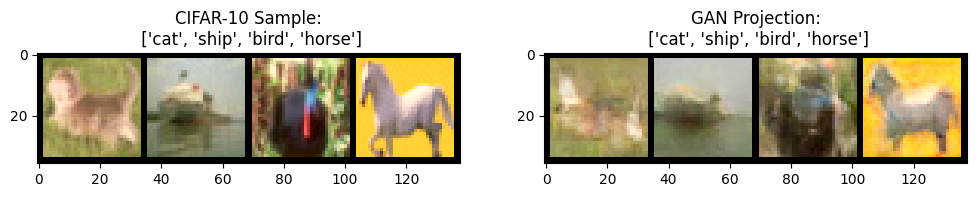

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get one image and label from CIFAR-10
image, labels = next(iter(adv_loader))
image = image.to(DEVICE)

projected_img, plot_data = project_onto_generator(generator, image, L, R, lr=0.253, verbose=True)

ax1.imshow(np.transpose(make_grid(image.cpu()).numpy(), (1, 2, 0)))
ax1.set_title(f"CIFAR-10 Sample:\n {[cifar10_dataset.classes[i] for i in labels]}")
ax2.imshow(np.transpose(make_grid(projected_img.cpu().detach()), (1, 2, 0)))
ax2.set_title(f"GAN Projection:\n {[cifar10_dataset.classes[i] for i in labels]}")
plt.show()

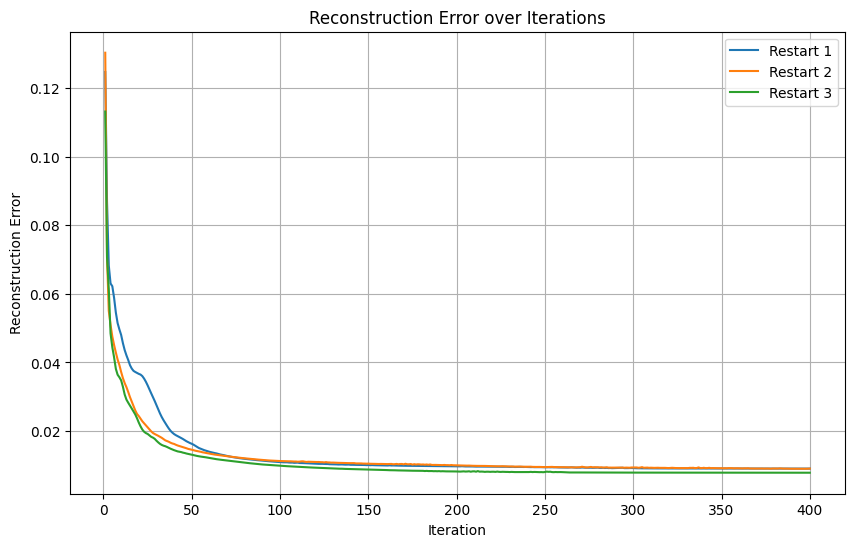

In [35]:
plot_reconstruction_errors(plot_data)

The rest of our pipeline is straightforward:

Learning Rate: 0.100000, Average Final Reconstruction Error: 0.012358
Learning Rate: 0.110000, Average Final Reconstruction Error: 0.012162
Learning Rate: 0.120000, Average Final Reconstruction Error: 0.011899
Learning Rate: 0.130000, Average Final Reconstruction Error: 0.011148
Learning Rate: 0.140000, Average Final Reconstruction Error: 0.011796
Learning Rate: 0.150000, Average Final Reconstruction Error: 0.011823
Learning Rate: 0.160000, Average Final Reconstruction Error: 0.012505
Learning Rate: 0.170000, Average Final Reconstruction Error: 0.010439
Learning Rate: 0.180000, Average Final Reconstruction Error: 0.011723
Learning Rate: 0.190000, Average Final Reconstruction Error: 0.010237
Learning Rate: 0.200000, Average Final Reconstruction Error: 0.011106
Learning Rate: 0.210000, Average Final Reconstruction Error: 0.011341
Learning Rate: 0.220000, Average Final Reconstruction Error: 0.009762
Learning Rate: 0.230000, Average Final Reconstruction Error: 0.010648
Learning Rate: 0.240

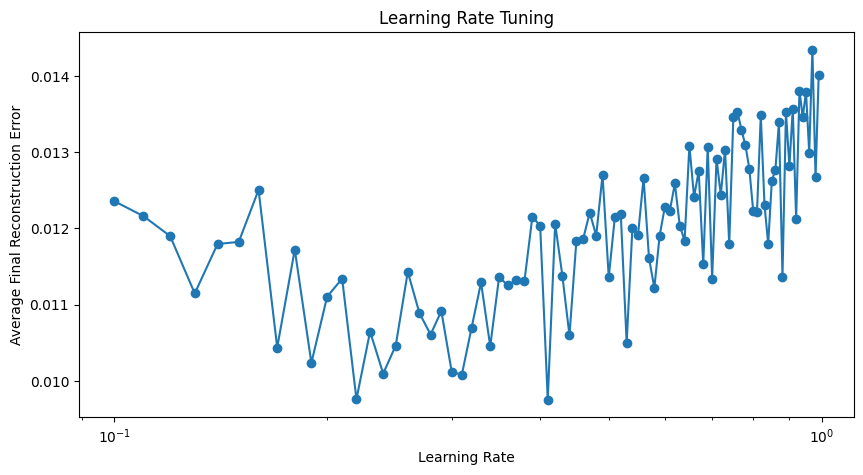

The best learning rate is: 0.41000000000000025


In [100]:
def find_best_learning_rate(generator, image, num_iterations, random_restarts, start_lr, end_lr, lr_step, verbose=False):
    """
    Finds the best learning rate by starting at a specific learning rate and incrementally increasing it.

    Args:
        generator (nn.Module): The generator model.
        image (torch.Tensor): The input image tensor.
        num_iterations (int): The number of iterations for optimization.
        random_restarts (int): The number of random restarts.
        start_lr (float): The starting learning rate.
        end_lr (float): The ending learning rate.
        lr_step (float): The increment step for the learning rate.
        verbose (bool): If set to True, prints out the reconstruction error for each learning rate.

    Returns:
        A tuple containing the best learning rate and a dictionary with learning rates and corresponding errors.
    """
    current_lr = start_lr
    reconstruction_errors = {}
    best_lr = start_lr
    best_error = float('inf')

    while current_lr <= end_lr:
        _, plot_data = project_onto_generator(generator, image, num_iterations, random_restarts, lr=current_lr, verbose=True)
        # Average the final reconstruction error over all random restarts.
        final_errors = [errors[-1] for errors in plot_data]
        avg_final_error = sum(final_errors) / len(final_errors)
        reconstruction_errors[current_lr] = avg_final_error

        if avg_final_error < best_error:
            best_error = avg_final_error
            best_lr = current_lr

        if verbose:
            print(f"Learning Rate: {current_lr:.6f}, Average Final Reconstruction Error: {avg_final_error:.6f}")

        current_lr += lr_step
    
    return best_lr, reconstruction_errors

# Define the starting and ending learning rates, and the step size.
start_lr = 0.1
end_lr = 1
lr_step = 0.01

# Get one image from CIFAR-10.
image, _ = next(iter(cifar10_loader))
image = image.to(DEVICE)

# Find the best learning rate.
best_lr, reconstruction_errors = find_best_learning_rate(
    generator, image, num_iterations=L, random_restarts=10, 
    start_lr=start_lr, end_lr=end_lr, lr_step=lr_step, verbose=True
)

# Plot the average final reconstruction error for each learning rate.
plt.figure(figsize=(10, 5))
plt.plot(list(reconstruction_errors.keys()), list(reconstruction_errors.values()), marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Average Final Reconstruction Error')
plt.title('Learning Rate Tuning')
plt.xscale('log')
plt.show()

print(f"The best learning rate is: {best_lr}")


In [27]:
def test_gan(generator: nn.Module, classifier: nn.Module, loader: DataLoader) -> torch.Tensor:

    sampleCnt = 0
    correctCnt = 0
    
    for _, (inputs, labels) in tqdm(enumerate(loader)):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # (1 - 2) Minimize & Generate 
        projected_inputs, _ = project_onto_generator(generator, inputs, L, R)


        # (2) Classify 
        outputs = classifier(projected_inputs)
        _, preds = torch.max(outputs, 1)

        correctCnt += torch.sum(preds == labels.data)
        sampleCnt += inputs.size(0)
        
        #print((correctCnt.double().cpu() / sampleCnt))
    return (correctCnt.double().cpu() / sampleCnt)
    

## **Defending Classifiers with DefenseGAN**

#### **Control**

As a control, we run our clean testing data through our pipeline. 

In [36]:
# VGG16
print(f"Testing accruacy: {test_gan(generator, vgg16, cifar10_loader)}")

# MobileNetV2
print(f"Testing accruacy: {test_gan(generator, mobilenet, cifar10_loader)}")

# ResNet18
print(f"Testing accruacy: {test_gan(generator, resnet, cifar10_loader)}")

2201it [2:08:06,  4.47s/it]

#### **FGSM**

In [78]:
def fetch_adv_loader(path: str, transforms: vt.transforms): 

    adv_dataset = AdversarialDataset(path, transform=transforms)
    adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return adv_loader



In [24]:
# Load datasets & create dataloaders 

adv_loader_vgg = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'fgsm'), transforms=adv_transforms)
adv_dataset_mobilenet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'fgsm'), transforms=adv_transforms)
adv_loader_resnet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'fgsm'), transforms=adv_transforms)

# Inference (with DefenseGAN)
print(f"Testing accruacy: {test_gan(generator, vgg16, adv_loader_vgg)}")
print(f"Testing accruacy: {test_gan(generator, mobilenet, adv_dataset_mobilenet)}")
print(f"Testing accruacy: {test_gan(generator, resnet, adv_loader_resnet)}")

1695
2101
1701


1it [00:13, 13.32s/it]

tensor(1.2500, dtype=torch.float64)


1it [00:18, 18.70s/it]


KeyboardInterrupt: 

#### **$L_\infty$**

In [12]:
# Load datasets & create dataloaders 
adv_loader_vgg = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'linfty'), transforms=adv_transforms)
adv_dataset_mobilenet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'linfty'), transforms=adv_transforms)
adv_loader_resnet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'linfty'), transforms=adv_transforms)

# Inference (with DefenseGAN)
print(f"Testing accruacy: {test_gan(generator, vgg16, adv_loader_vgg)}")
print(f"Testing accruacy: {test_gan(generator, mobilenet, adv_dataset_mobilenet)}")
print(f"Testing accruacy: {test_gan(generator, resnet, adv_loader_resnet)}")

157it [29:38, 11.33s/it]


Testing accruacy: 6.7378


99it [18:59, 11.51s/it]


KeyboardInterrupt: 

## **Results**

Here are the tabulated results of DefenseGAN against two white-box attacks (FGSM & $L_\infty$).
| Model | No Attack | FGSM Attack | $L_{\infty}$ Attack |
| -----| ---------|  -----------| ---------------|
| VGG16 | 93.04% | 0.94% | 0.003% |
| MobileNetV2 | 92.26% | 1.38% | 0% |
| ResNet18 | 94.73% | 1.69% | 0.1% | 
| VGG16 (With DefenseGAN) | 49.66% |
| MobileNetV2 (With DefenseGAN) |  
| ResNet18 (With DefenseGAN) | 
